# Hackathon: The Ultimate Student Hunt

#### Sources:

- [Biostatistics handbook](http://www.biostathandbook.com/)
- [Weather properties](http://www.conservationphysics.org/atmcalc/atmoclc1.php)
- [Kaggle ensembling tutorial](http://mlwave.com/kaggle-ensembling-guide/)
- [arima](https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/)
- [sarimax](https://github.com/ChadFulton/statsmodels/blob/master/examples/notebooks/statespace_sarimax_stata.ipynb)
- [Exponential smoothing of time series](https://www.otexts.org/fpp/7)

In [1]:
import pandas as pd
import numpy as np
import tabulate
%matplotlib inline
import matplotlib.pyplot as plt
import datetime as dt
import statsmodels.api as sm
from time import time
from scipy.stats import ttest_ind,f_oneway
from scipy import poly1d, polyfit

In [2]:
# load data
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')
backup_train = train.copy()
backup_test = test.copy()

train_indices = train.index
train_labels = train.Footfall
columns = train.columns
data = pd.concat([train[columns[:-1]],test],ignore_index=True)

### data cleaning
- datatypes
- missing values
- zero-variance variables
- transformation (rescale, normalization, ...)

In [3]:
# methods
def validate_data_set(df):
    """
    checks the validity variables of a dataset. 
    It looks for datatypes, number of unique values and number of missing values
    df (pandas.dataframe): dataset
    """
    s = []
    for col in df.columns:
        s.append((col,df[col].dtype,len(pd.unique(df[col])),
                  round(100*df[df[col].isnull()].shape[0]/float(df.shape[0]),2)))
    print tabulate.tabulate(s,['Label','dtype','# unique values','# missing values (%)','Var'])
    
def string2date(x):
    """
    convert string date of format dd-mm-yyyy to datetime format
    input:
    x (str): date
    output:
    y (datetime)
    """
    return pd.datetime.strptime(x,'%d-%m-%Y').date()

def impute_nans(x,method):
    """
    replace NaN with the mean, median or most_frequent
    input:
    x (pandas.Series): array to be imputed
    method {'mean','median','most_frequent'}: method to be used in the imputation. Note that
    most_frequent works on categorical only
    output:
    y1 (pandas.Series): array with NaNs replaced by the method
    y2 (float,int,str): the value used to replace NaNs
    """
    if method == 'mean':
        val = x.mean()
        x = x.fillna(val)
    if method == 'median':
        val = x.median()
        x = x.fillna(val)
    if method == 'most_frequent':
        val = x.mode().values[0]
        x = x.fillna(val)
    return x,val

In [4]:
validate_data_set(data)

Label                         dtype      # unique values    # missing values (%)
----------------------------  -------  -----------------  ----------------------
ID                            int64               153959                    0
Park_ID                       int64                   28                    0
Date                          object                5600                    0
Direction_Of_Wind             float64                360                    3.52
Average_Breeze_Speed          float64                188                    3.52
Max_Breeze_Speed              float64                 30                    3.53
Min_Breeze_Speed              float64                 19                    3.52
Var1                          float64                493                    7.28
Average_Atmospheric_Pressure  float64                178                   34.66
Max_Atmospheric_Pressure      float64                176                   34.66
Min_Atmospheric_Pressure      float64

From this table we can do appropriate cleaning:
    - datatypes: Date (convert to datetime), Location_Type (can be labeled using dummies since it's un-ordered categorical)
    - missing values: NaNs to be replaced by mean (if distribution are symmetric) or median (ortherwise) by Park_ID.
Note: for variables with missing values >20%, one should think of a better way to impute missing values. They can be draw from a distribution of non missing values
    

In [5]:
# datatypes
tic = time()
# convert date in datatime datatype
data['Date'] = data.Date.apply(lambda x:string2date(x))

# treat missing values
methods = {
    'median':['Direction_Of_Wind','Average_Breeze_Speed','Max_Breeze_Speed','Min_Breeze_Speed',
              'Var1','Min_Ambient_Pollution','Max_Ambient_Pollution','Average_Moisture_In_Park',
              'Max_Moisture_In_Park','Min_Moisture_In_Park'],
    'mean':['Average_Atmospheric_Pressure','Max_Atmospheric_Pressure','Min_Atmospheric_Pressure',
            ]
}
nan_substitutes = {}
park_ids = sorted(pd.unique(data.Park_ID))
for k,v in methods.iteritems():
    for pid in park_ids:
        nan_substitutes[pid] = {}
        indices = data[data.Park_ID==pid].index
        for col in v:
            if sum(~(data.loc[indices,col].isnull()))>0:
                imputes = impute_nans(data.loc[indices,col],k)
                data.loc[indices,col] = imputes[0]
                nan_substitutes[pid][col] = imputes[1]
            else:
                data.loc[indices,col] = 0
                nan_substitutes[pid][col] = 0
print "Processing time:", round(time()-tic,2)

Processing time: 5.37


In [6]:
#validate_data_set(data)
#nan_substitutes

In [7]:
#transform location_type to dummies
#print "shape before:",data.shape

#data = pd.concat([data,pd.get_dummies(data.Location_Type,prefix='Location')],
#                 axis=1,join_axes=[data.index])
#print "shape after:",data.shape

### data engineering
**Derive new variables based on hypothesis**
    - Footfall depends on the seasons. From date, we derive Year, Month, Week, Day_Of_Month, Day_Of_Week
    - Footfall depends on the variance of the weather. When the weather (temparature) is high and not variable during a day, people like to go to the beach. But when the weather varies over a broad range, the weather is unpredictable and people are skeptical. I think the same may apply to parks. Therefore, from each variable with max and min, we will derive the Range of the variable as the difference between min and max: Range_Breeze, Range_Atmospheric_Pressure, Range_Ambient_Pollution, Range_Moisture_In_Park
    - The number of park visitors today might influence the number of visitors tomorrow. I suspect a markov behavior. We will add a variable to test this

In [8]:
# date/time variables
data['Year'] = data.Date.apply(lambda x:x.year)
data['Month'] = data.Date.apply(lambda x:x.month)
data['Week'] = data.Date.apply(lambda x:x.isocalendar()[1])
data['Day_Of_Month'] = data.Date.apply(lambda x:x.day)
data['Day_Of_Week'] = data.Date.apply(lambda x:x.weekday())
data['Day_Of_Year'] = data.Date.apply(lambda x:x.timetuple().tm_yday)

In [9]:
# variance of weather metrics
data['Range_Breeze_Speed'] = data.Max_Breeze_Speed - data.Min_Breeze_Speed
data['Range_Atmospheric_Pressure'] = data.Max_Atmospheric_Pressure - data.Min_Atmospheric_Pressure
data['Range_Ambient_Pollution'] = data.Max_Ambient_Pollution - data.Min_Ambient_Pollution
data['Range_Moisture_In_Park'] = data.Max_Moisture_In_Park - data.Min_Moisture_In_Park

In [10]:
# create backup
backup_data = data.copy()

# split back train from test
train = data.loc[train_indices]
train['Footfall'] = train_labels
test = data.loc[~(data.index.isin(train_indices))]

### Exploratory Data Analysis


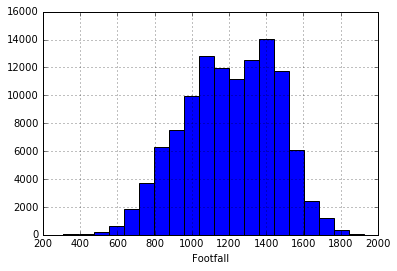

In [11]:
#Footfall
train.Footfall.hist(bins=20)
plt.xlabel('Footfall')
plt.show()

- The target variable looks like a bimodal distribution

In [12]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,153959.0,3.589564e+06,161317.432817,3311712.0,3450019.50,3.587437e+06,3729124.50,3871639.00
Park_ID,153959.0,2.562309e+01,8.100157,12.0,18.00,2.600000e+01,33.00,39.00
Direction_Of_Wind,153959.0,1.732721e+02,89.838081,0.0,98.00,1.930000e+02,236.00,360.00
Average_Breeze_Speed,153959.0,3.310853e+01,18.287731,0.0,21.28,3.040000e+01,41.80,154.28
Max_Breeze_Speed,153959.0,4.998128e+01,23.740354,0.0,38.00,4.560000e+01,60.80,220.40
Min_Breeze_Speed,153959.0,1.670762e+01,14.545180,0.0,7.60,1.520000e+01,22.80,129.20
Var1,153959.0,1.732109e+01,36.896125,0.0,0.00,2.490000e-02,18.26,1181.09
Average_Atmospheric_Pressure,153959.0,5.617412e+03,3905.409120,0.0,0.00,8.290000e+03,8358.00,8588.00
Max_Atmospheric_Pressure,153959.0,5.633991e+03,3916.870490,0.0,0.00,8.314000e+03,8379.00,8601.00
Min_Atmospheric_Pressure,153959.0,5.599948e+03,3893.355474,0.0,0.00,8.259000e+03,8335.00,8571.00


In [13]:
# functions
def generate_boxplot(df,target,variable,ylimits):
    df.boxplot(target,variable)
    plt.ylim(ylimits)
    plt.xlabel(variable)
    plt.ylabel(target)
    plt.title(target+' vs. '+variable)
    plt.show()
    

def generate_histogram(df,target,variable):
    hx = np.histogram(df[target])[1]
    cats = sorted(pd.unique(df[variable]).tolist())
    w = 0.8*(hx[1]-hx[0])/float(len(cats))
    colors = plt.cm.jet_r(np.linspace(0,1,len(cats)))
    for i,cat in enumerate(cats):
        h = np.histogram(df[df[variable]==cat][target],bins=hx)
        plt.bar(hx[:-1]+i*w,h[0],width=w,color=colors[i])
        plt.xlabel(target)
        plt.ylabel('Count')
        plt.legend(cats,title=variable,loc='best')
    plt.title(target+' vs. '+variable)
    plt.show()
    
def run_stat_test(df,variable,target):
    cats = sorted(pd.unique(df[variable]).tolist())
    if len(cats)>2:
        #use one way anova
        cmd = 'f_oneway(df[df[variable]==cats[0]][target],'
        for cat in cats[1:]:
            cmd+='df[df[variable]=='+str(cat)+'][target],'
        cmd = cmd[:-1]+')'
        print "One way anova test:",eval(cmd)
    else:
        #use t-student test
        print "ttest:",ttest_ind(data[data[variable]==cats[0]][target],
                                 data[data[variable]==cats[1]][target],
                                 False)
    pass

def visualize_categorical(variable,target='Footfall',df=train,method='boxplot',
                         ylimits=[0,100]):
    """
    Use this function to visualize categorical variables.
    This plots the distribution of the  variable and the box plot of 
    the target variable by categoris in the dependent variable
    input:
    variable (str): variable in the training set
    """
    if method=='boxplot':
        generate_boxplot(df,target,variable,ylimits)
    if method=='histogram':
        generate_histogram(df,target,variable)
    
    # run statistical test
    run_stat_test(df,variable,target)
    
def visualize_numerical(variable,target='Footfall',df=train,bins=10,color='b',size=30):
    """
    Use this function to visualize continuous numerical variables.
    This plots the distribution of the  variable and the scatter plot  
    the target variable by the dependent variable
    input:
    variable (str): variable in the training set
    target (str): target variable
    df (pandas.dataframe): training set
    """
    
    xvals = df[variable]
    yvals = df[target]
    # genererate the histogram
    fig,ax = plt.subplots(1,2,figsize=(14,5))
    ax[0].hist(xvals,bins=bins)
    ax[0].set_xlabel(variable)
    ax[0].set_ylabel('Count')
    
    ax[1].scatter(xvals,yvals,c=color,s=size,marker='.',alpha=0.3)
    ax[1].set_xlabel(variable)
    ax[1].set_ylabel(target)
    
    #if type(color)!= str:
    #    ax[1].legend(pd.unique(color).tolist())
    plt.show()

##### Observations from Exploration

*By data type*
- Numerical (Continuous):
    - ID: the target is periodic with respect to ID
    - Direction_Of_Wind: bimodal (Gaussian + left tail gaussian), two peaks at 70 and 190 (highest). This variable is separable by Month,i.e, different months have different mean values direction of wind
    - Breeze_Speed: These variables are all skewed to the right. They are also different in different months, Park_ID
    - var1: prone to outliers. Skewed to the right. Separable by Month, Week
    - Atmospheric_Pressure variables: Gaussian. Separable by Month, Week
    - Ambient_Pollution variables: skewed to the left. Separable by Month
- Categorical:
    - Partk_ID: skewed distribution, Footfall separable (pval<0.05)
    - Location_Type: Gaussian, Footfall not separable (pval>0.05)
    - Year: Gaussian. Footfall not separable (pval>0.05)
    - Month: Gaussian. Football separable (pval=0.0). Footfall seems periodic in time
    - Week: Gaussian. Football separable (pval=0.0). Footfall seems periodic in time
    - Day_Of_Week: Gaussian. Not separable (pval>0.05)
- Dates:
    - Date: Footfall is periodic in time. One may try to fit an analytical model first
    
*Miscellaneous*
- Park_ID can be clustered by Location_Type:
    - 1: [15, 16, 24, 34]
    - 2: [17, 21, 23, 26, 28, 29, 32, 35]
    - 3: [12, 14, 20, 25, 27, 30, 33, 37, 38, 39]
    - 4: [13, 18, 19, 22, 31, 36]
- The number of visitors decreases in the periods of high fluctuations of Atmosperic pressure. (Use rolling mean and std to capture this or use signal modulation)
- There is seasonality in Min_Moisture_In_Park metrics, Max_Ambient_Pollution
*Park without records of metrics*: Some parks were found to have no records the atmospheric pressure or/and the ambient pollution:
- Atmospheric pressure:
- Ambient pollution:



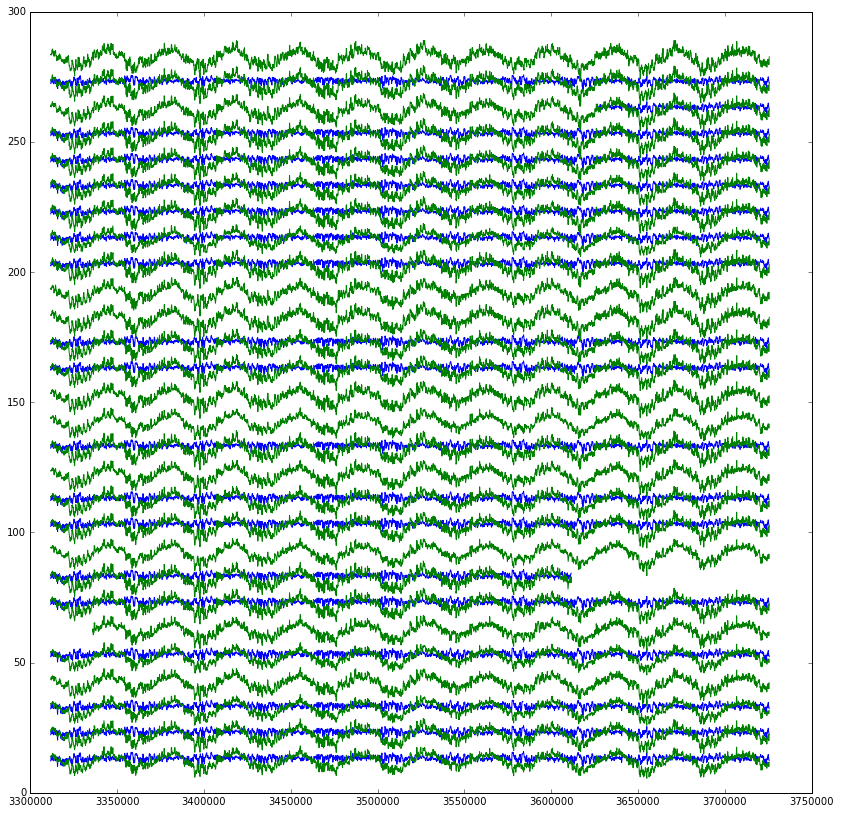

In [14]:

#plt.plot(train.Month,train.Footfall,'.')
#visualize_numerical('Min_Ambient_Pollution',bins=20,color=df.Park_ID,size=100)
#visualize_categorical('Month',ylimits=[700,1600],method='boxplot')

#visualize by park id
colors = plt.cm.jet_r(np.linspace(0,1,len(park_ids)))
plt.figure(figsize=(14,14))
for i,pid in enumerate(park_ids):
    df = backup_train[backup_train.Park_ID==pid]
    #Atmospheric Pressure
    plt.plot(df.ID,(df.Average_Atmospheric_Pressure.values/100.+10*i-70),c='b') 
    plt.plot(df.ID,df.Footfall.values/100.+10*i,c='g')


#plt.legend(park_ids)
plt.show()


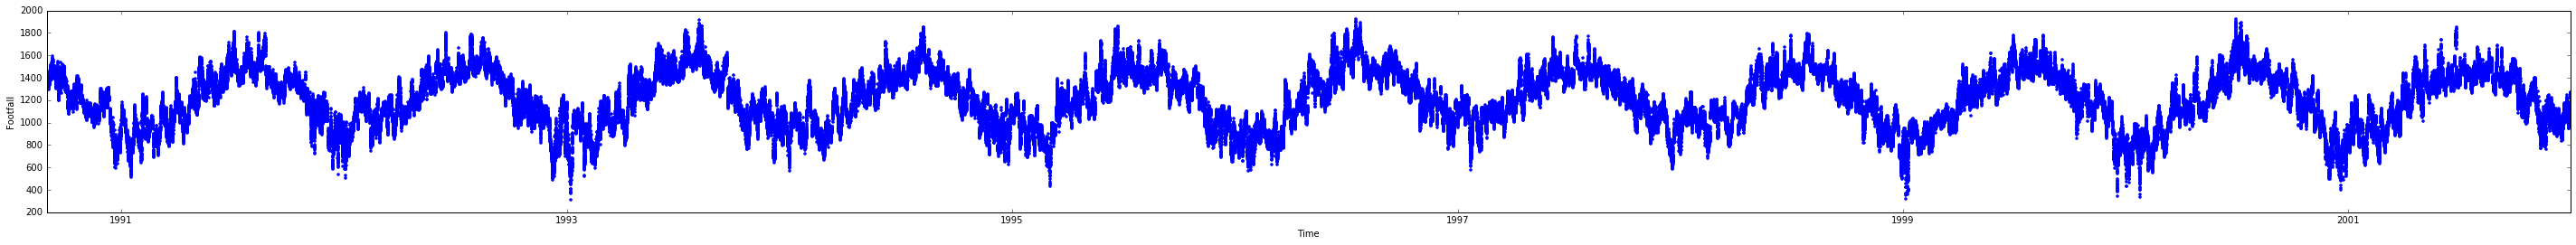

In [15]:
# date
plt.figure(figsize=(50,4))
plt.plot(train.Date,train.Footfall,'.')
plt.xlabel('Time')
plt.ylabel('Footfall')
plt.show()

### Model Building

In [16]:
from scipy.stats import linregress
from sklearn.metrics import mean_squared_error

The footfall was found periodic in time:
    - Does the number of visitors today influence the number of visitors tomorrow?
    - plot time series by Park_ID. We see tiny oscillations which may be due to the fact that we have different locations
    - We can even try to cluster Park_ID based on other periodic variables
    - The imputation of missing values should be return using interporation with respect to time
    
There is one and only one row per day for each Park_ID

The above RMSE is too big compared to the leaderboard. So, this was a bad idea. Next, let's build a time series model

##### A. Simple Timeseries Model

We fit a sine function to the Footfall

In [17]:
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy.fftpack import fft
def fx(x,A,a,b,B):
    return A*np.sin(a*x-b)+B

In [18]:
# train the model
model_params = {}
resids_params = {}
residues = []
pids = sorted(pd.unique(train.Park_ID))
for pid in pids:
    df = train[train.Park_ID == pid]
    x = df.ID.values
    A,a,b,B = curve_fit(fx,df.ID.values,df.Footfall.values,[500,0.00018,1.5,1200])[0]
    ypred = fx(x,A,a,b,B)
    resids = ypred-df.Footfall.values
    residues.extend(zip(x,resids))
    # model residues
    df2 = df.copy()
    df2['Residues'] = resids
    resids_params[pid] = {}
    for week in range(1,54):
        d = df2[df2.Week == week]['Residues']
        resids_params[pid][week] = (d.mean(),d.std())
    model_params[pid] = (A,a,b,B)
    #print pid,np.sqrt(mean_squared_error(df.Footfall.values,ypred))
residues_df = pd.DataFrame(residues,columns=['ID','Residues'])

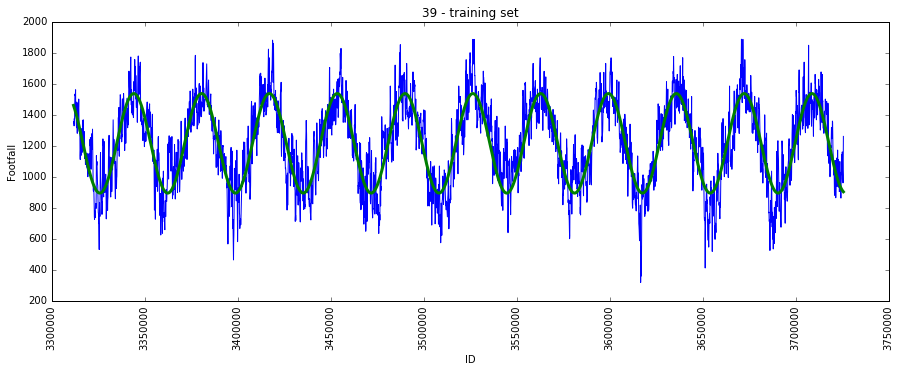

In [19]:
train = pd.merge(train,residues_df,right_on='ID',left_on='ID')

plt.figure(figsize=(15,5))
plt.plot(df.ID,df.Footfall)
plt.plot(df.ID.values,ypred,linewidth=3)
plt.title(str(pid)+' - training set')
plt.xticks(rotation='vertical')
plt.xlabel('ID')
plt.ylabel('Footfall')
plt.show()

#train['Predictions'] = train.Footfall + train.Residues

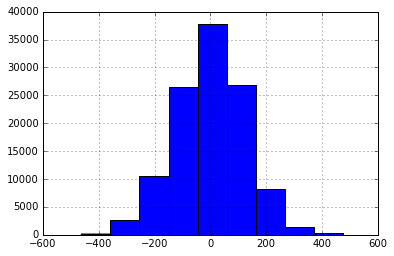

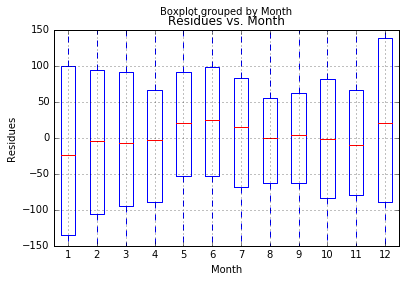

One way anova test: F_onewayResult(statistic=111.55546923675023, pvalue=5.7911414328692897e-255)


In [20]:
## Model residues
train.Residues.hist()
plt.show()
visualize_categorical('Month','Residues',df=train,ylimits=[-150,150])

Residues are normally distributed and they peak in June

In [21]:
# make predictions
pids_test = sorted(pd.unique(test.Park_ID))
ypreds = []
for pid in pids_test:
    tic = time()
    df = test[test.Park_ID == pid]
    x = df.ID.values
    A,a,b,B = model_params[pid]
    ypred = fx(x,A,a,b,B)
    ypreds.extend(zip(x,ypred))
    #print pid, round(time()-tic)

submission = pd.DataFrame(ypreds,columns = ['ID','Footfall']).sort_values('ID')
#submission.to_csv('submission_sine_fit.csv')

- Improving the model: we will try to make a model on residuals which will later serve as a correction to the initial period sine model

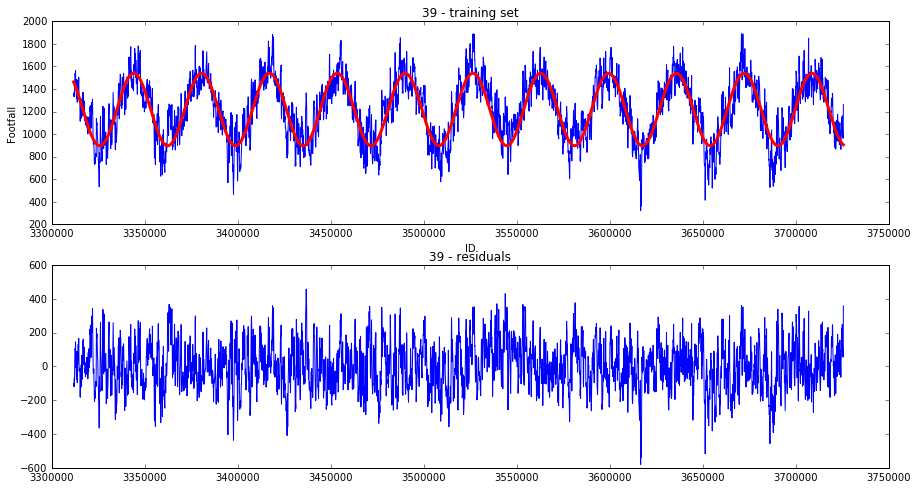

RMSE: 136.998373708


In [22]:
# train the model
model_params = {}
pids = sorted(pd.unique(train.Park_ID))
pid = 39
df = train[train.Park_ID == pid]
x = df.ID.values
A,a,b,B = curve_fit(fx,df.ID.values,df.Footfall.values,[500,0.00018,1.5,1200])[0]
ypred = fx(x,A,a,b,B)

residuals = df.Footfall.values - ypred
fig,ax = plt.subplots(2,1,figsize=(15,8))
ax[0].plot(df.ID,df.Footfall)
ax[0].plot(df.ID.values,ypred,linewidth=3, color='red')
ax[0].set_title(str(pid)+' - training set')
ax[0].set_xlabel('ID')
ax[0].set_ylabel('Footfall')

ax[1].plot(df.ID,residuals)
ax[1].set_title(str(pid)+' - residuals')
plt.show()
print "RMSE:", np.sqrt(mean_squared_error(df.Footfall.values,ypred))

### Model Improvement

- Is there any trend over the year? **NO**
- Is there any trend in residuals? **NO**
- Is there any autoregression between residuals?**There appear to be no trend but residues are markovian. There is a correlation between residues on two consecutive days - See figure below**
- Is there any correlation between residuals and predictions?

In [24]:
def residues_linfit(x,df):
    """
    find the slope b and intercept m of the line between  residues tomorrow vs residues today from dataframe df
    Then return bx+m as the fit
    """
    a,m = polyfit(df.Residues.values[:-1], df.Residues.values[1:],1).tolist()
    return a*x+m


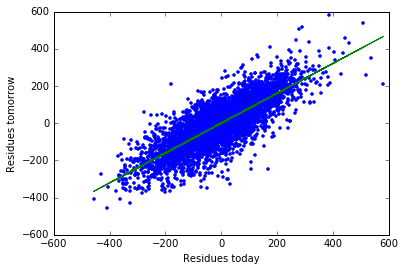

In [25]:
plt.plot(df.Residues,df.Residues.shift(1),'.')
plt.plot(df.Residues,residues_linfit(df.Residues.values,df))
plt.xlabel('Residues today')
plt.ylabel('Residues tomorrow')
plt.show()

In [26]:
df.pivot_table(index='Year',columns='Month',values='Residues',aggfunc='mean').mean()

Month
1    -10.653311
2     -9.315839
3     -0.200464
4    -10.717932
5      9.490024
6     12.535111
7     -3.971580
8     -6.649113
9      0.898622
10    -1.500480
11    -9.947446
12    27.337845
dtype: float64

### SARIMAX

In [27]:
df.index = pd.DatetimeIndex(df.Date)

In [29]:
# split into train, validation and test
dtrain = df.loc['1991-01-01':'1999-12-31']
dvalid = df.loc['2000-01-01':'2001-12-31']

# train model
mod = sm.tsa.statespace.SARIMAX(endog=dtrain.Footfall,trend='n',order=(1,0,1),
                                seasonal_order=(1,0,1,12),simple_differencing=True)
res = mod.fit()

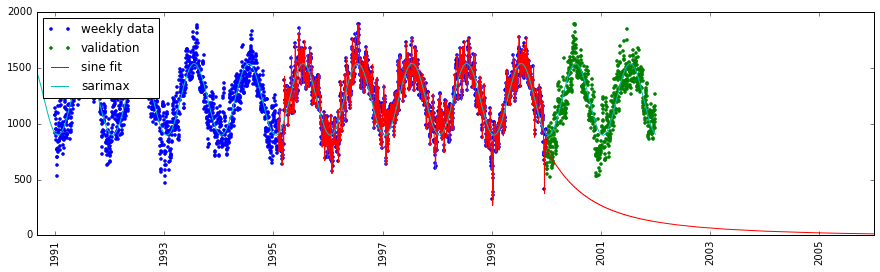

In [30]:
# make predictions
plt.figure(figsize=(15,4))
predictions = res.predict(start = '1995-01-31', end = '2005-12-30')
plt.plot(dtrain.loc['1991-01-01':,'Footfall'],'.') #plot data of the last three years
plt.plot(dvalid.loc['2000-01-01':,'Footfall'],'.') #plot data of the last three years
plt.plot(predictions) #overlay the predictions from one last year up to 1 year in the future
plt.plot(df.Date.values,ypred,linewidth=1, color='c')
plt.xticks(rotation='vertical')

plt.legend(['weekly data','validation','sine fit','sarimax'],loc=2)

plt.show()